In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

### Figure 2A is based on several important BED-files ...

In [4]:
feat_names = OrderedDict()
# list of TTS that belong to genes active both in HAP1 and HCT116
feat_names["tts"] = "ActiveTTS-woH3K4-woCTCF-8894-1bp_HCT116_HAP1.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end","strand"],
        usecols=(0,1,2,3),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


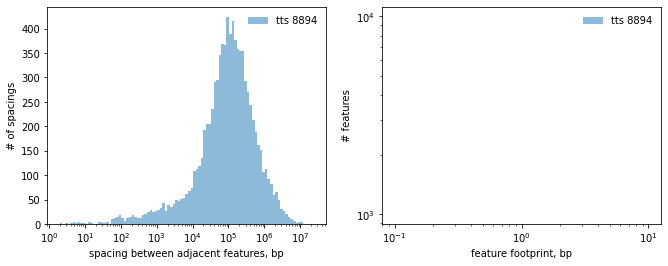

In [6]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [7]:
#let's describe our samples that we want to have in Figure 1 ...
fig2a_samples = ["ins_CTCF","ins_noCTCF",
                "ins_rad21","ins_norad21",
                "ins_waplWT","ins_waplKO3",
                "ins_polII","ins_nopolII",
                "rad21_CTCF","rad21_noCTCF",
                "rad21_rad21",
                'h3k4_r1','h3k4_hct',
               ]

titles = fig2a_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig2a_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [8]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features tts:(8894) ...


stacking up ins_CTCF ...
CPU times: user 886 ms, sys: 32.6 ms, total: 919 ms
Wall time: 914 ms
stacking up ins_noCTCF ...
CPU times: user 893 ms, sys: 46.2 ms, total: 939 ms
Wall time: 937 ms
stacking up ins_rad21 ...
CPU times: user 921 ms, sys: 35.9 ms, total: 957 ms
Wall time: 952 ms
stacking up ins_norad21 ...
CPU times: user 925 ms, sys: 34.4 ms, total: 959 ms
Wall time: 981 ms
stacking up ins_waplWT ...
CPU times: user 871 ms, sys: 40.3 ms, total: 912 ms
Wall time: 908 ms
stacking up ins_waplKO3 ...
CPU times: user 872 ms, sys: 44 ms, total: 916 ms
Wall time: 914 ms
stacking up ins_polII ...
CPU times: user 849 ms, sys: 32.1 ms, total: 881 ms
Wall time: 879 ms
stacking up ins_nopolII ...
CPU times: user 852 ms, sys: 7.89 ms, total: 860 ms
Wall time: 858 ms
stacking up rad21_CTCF ...
CPU times: user 1.18 s, sys: 64.1 ms, total: 1.25 s
Wall time: 1.24 s
stacking up rad21_noCTCF ...
CPU times: user 1.01 s, sys: 43.7 ms, total: 1.05 s
Wall t

### add a couple more "custom" tracks based on BigBed files (genes, peaks, etc)...

In [9]:
#!ls NT2_K562_DRIP.bb
annot_flank = 5_000
annot_binsize = 200
feat_name = "rloops"
for k in dfs:
    print(f"stacking R-loop footprints up for {k} ...")
    stackup_dict[k][feat_name] = rstacks(
        "NT2_K562_DRIP.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )

fig2a_samples.append(feat_name)
titles = fig2a_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

stacking R-loop footprints up for tts ...


In [10]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig2a_samples.append(feat_name)
titles = fig2a_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for tts ...


### Compartment (EV1-based) flipping here as well !
#### need to get to the bottom of this !!!

In [11]:
flip_stackup_dict = OrderedDict()
for k in dfs:
    # flippin separately for each set ...
    print(f"preparing to flip {k} ...")
    the_stackup = stackup_dict[k]
    # we'll be flipping according to gene orientation ....
    the_strand = dfs[k]["strand"]
    preflip_index = the_strand.index

    # flipped index according to EV1
    flip_stackup_index = np.concatenate([
        preflip_index[the_strand=="+"],
        preflip_index[the_strand=="-"],
        preflip_index[pd.isna(the_strand)] # don't forget to bring NaN-filled EVs back in
    ])
    
    assert (np.sort(flip_stackup_index) == preflip_index).all()

    # flip EVERYTHING according to the strand
    flip_stackups = {}
    for s in bw_fnames:
        flip_stackups[s] = np.concatenate([
            the_stackup[s][the_strand=="+"],
            (-1 if s=="gene" else 1) * the_stackup[s][the_strand=="-"][:,::-1],
            the_stackup[s][pd.isna(the_strand)] # keep NaN-filled items along unperturbed
        ])[np.argsort(flip_stackup_index)]
    # !!! Make sure rows in the stackups are re-sorted back the same way
    # ro ensure they are in sync with the input BED-files !
        
    # print flip condition numbers ...
    sum_p = (the_strand=="+").sum()
    sum_m = (the_strand=="-").sum()
    sum_n = pd.isna(the_strand).sum()

    print(f"initial number of items {len(the_strand)}, intact {sum_p}, flipped {sum_m} , NaN-filled {sum_n}")
    print(f"{sum_p} + {sum_m} + {sum_n} = {sum_p+sum_m+sum_n}")
    
    # save flipped the_stackup to the new OrderedDict ...
    flip_stackup_dict[k] = flip_stackups


preparing to flip tts ...
initial number of items 8894, intact 4483, flipped 4411 , NaN-filled 0
4483 + 4411 + 0 = 8894


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [12]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in flip_stackup_dict:
    the_stackup = flip_stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [13]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

#### Sorting ...

In [14]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['rloops'].shape
    center_bin = int(width/2)

    the_stackups['rloops_mean'] = np.nanmean(the_stackups['rloops'][:,:],axis=1)
    _sorting_key = 'rloops_mean'
    _, _jjj = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(the_stackups[_sorting_key]) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 8894 elements of rloops_mean into 1 groups ...


#### plotting those running averages is integrated into `plot_stackups` function ...

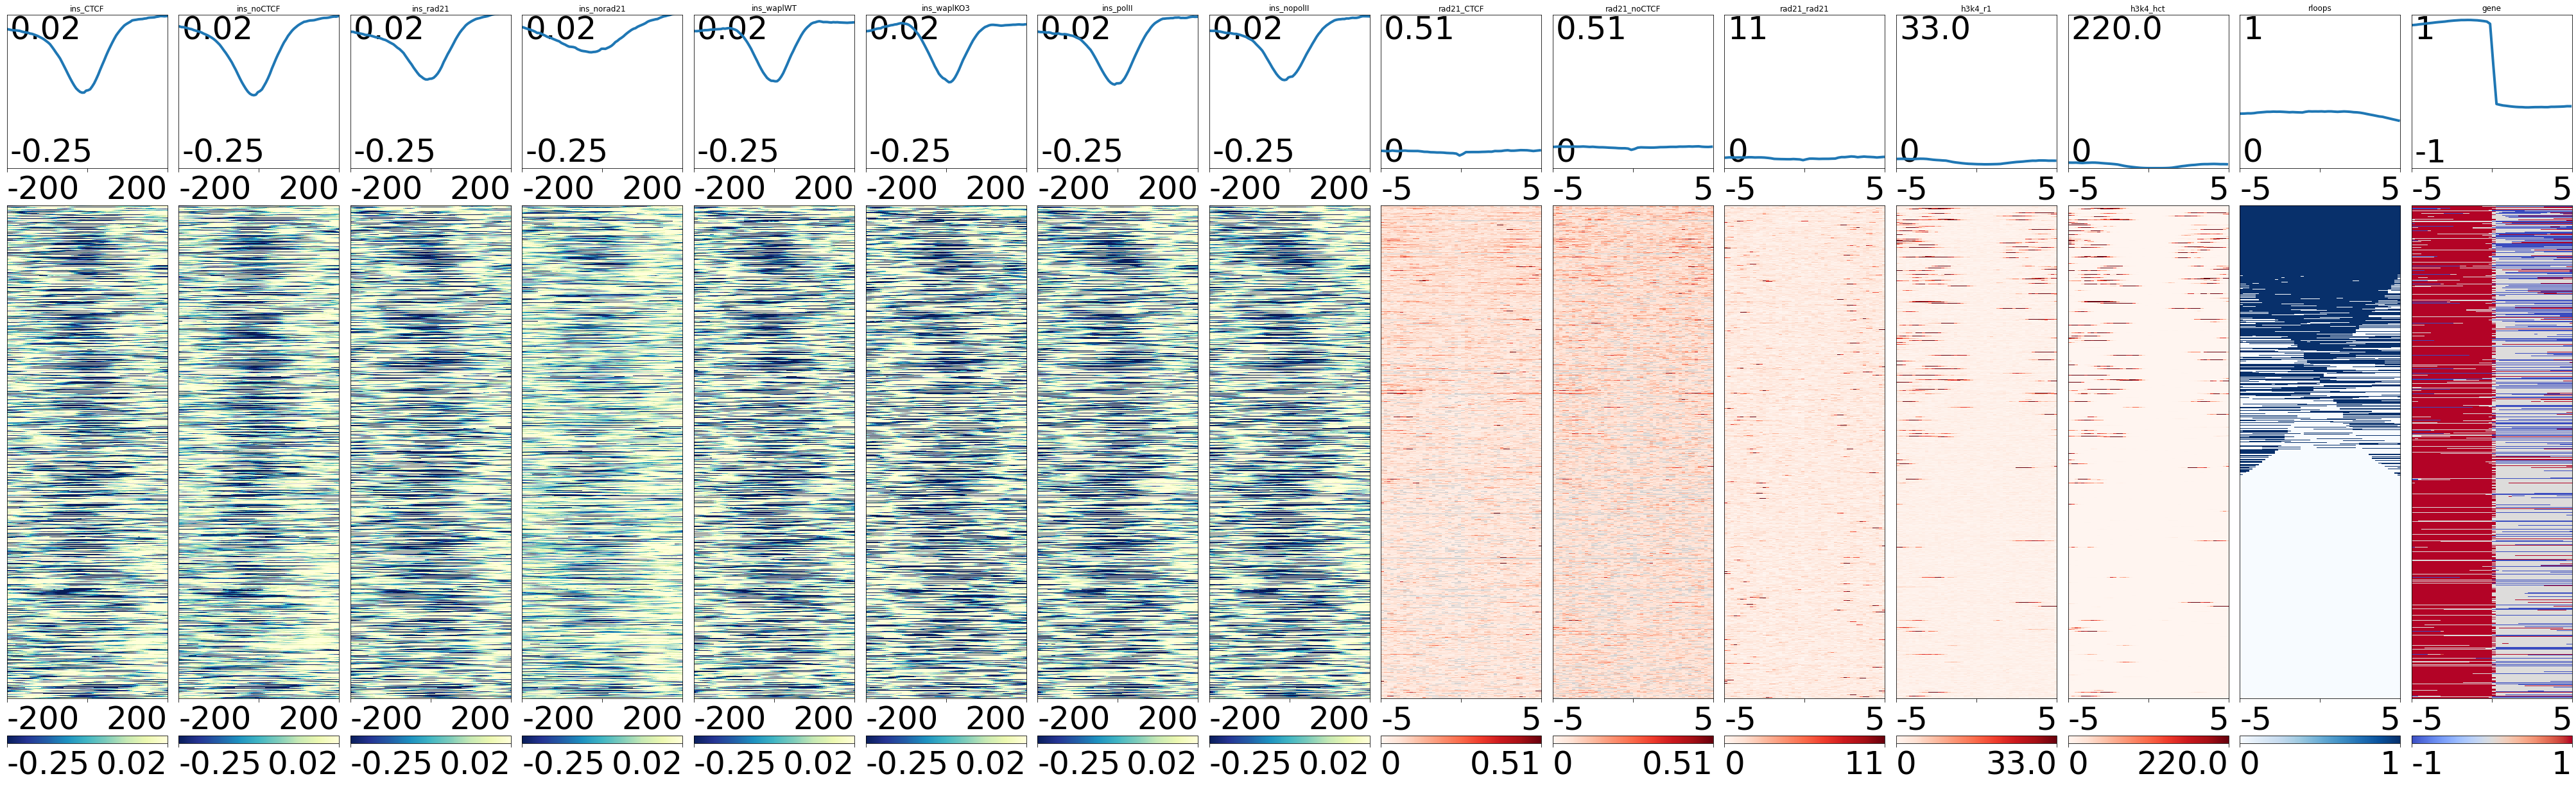

In [15]:
hmss = OrderedDict()

for feature_key in dfs.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig2a_samples ]

_limss = [ limss[_k] for _k in fig2a_samples ]
_cmps = [ cmps[_k] for _k in fig2a_samples ]
_binsizes = [ binsizes[_k] for _k in fig2a_samples ]
_norms = [ norms[_k] for _k in fig2a_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("Fig2A-TTS-HAP1-HCT-common-November.pdf")

In [16]:
!scp Fig2A-TTS-HAP1-HCT-common-November.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig2A-TTS-HAP1-HCT-common-November.pdf        100% 1442KB   3.8MB/s   00:00    


#### "Define" TTSs with and without R-loop ...

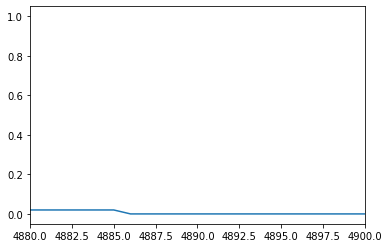

In [17]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    jjj = reordered_jdxs[feature_key]
    plt.plot(the_stackups['rloops_mean'][jjj])
    
ax = plt.gca()
ax.set_xlim(4880,4900)
# there are ~5770 of Rloop+ TSS and TTS -> let's select them !
# there are ~4885 when looking at the common HAP1/HCT116 genes
number_TTS_wrloop = 4885

### Try to look at TTS with R-loop present ... - resorted differently ...

#### Not used in the paper

sorting 4885 elements of gene_mean into 1 groups ...
ready to plot ...


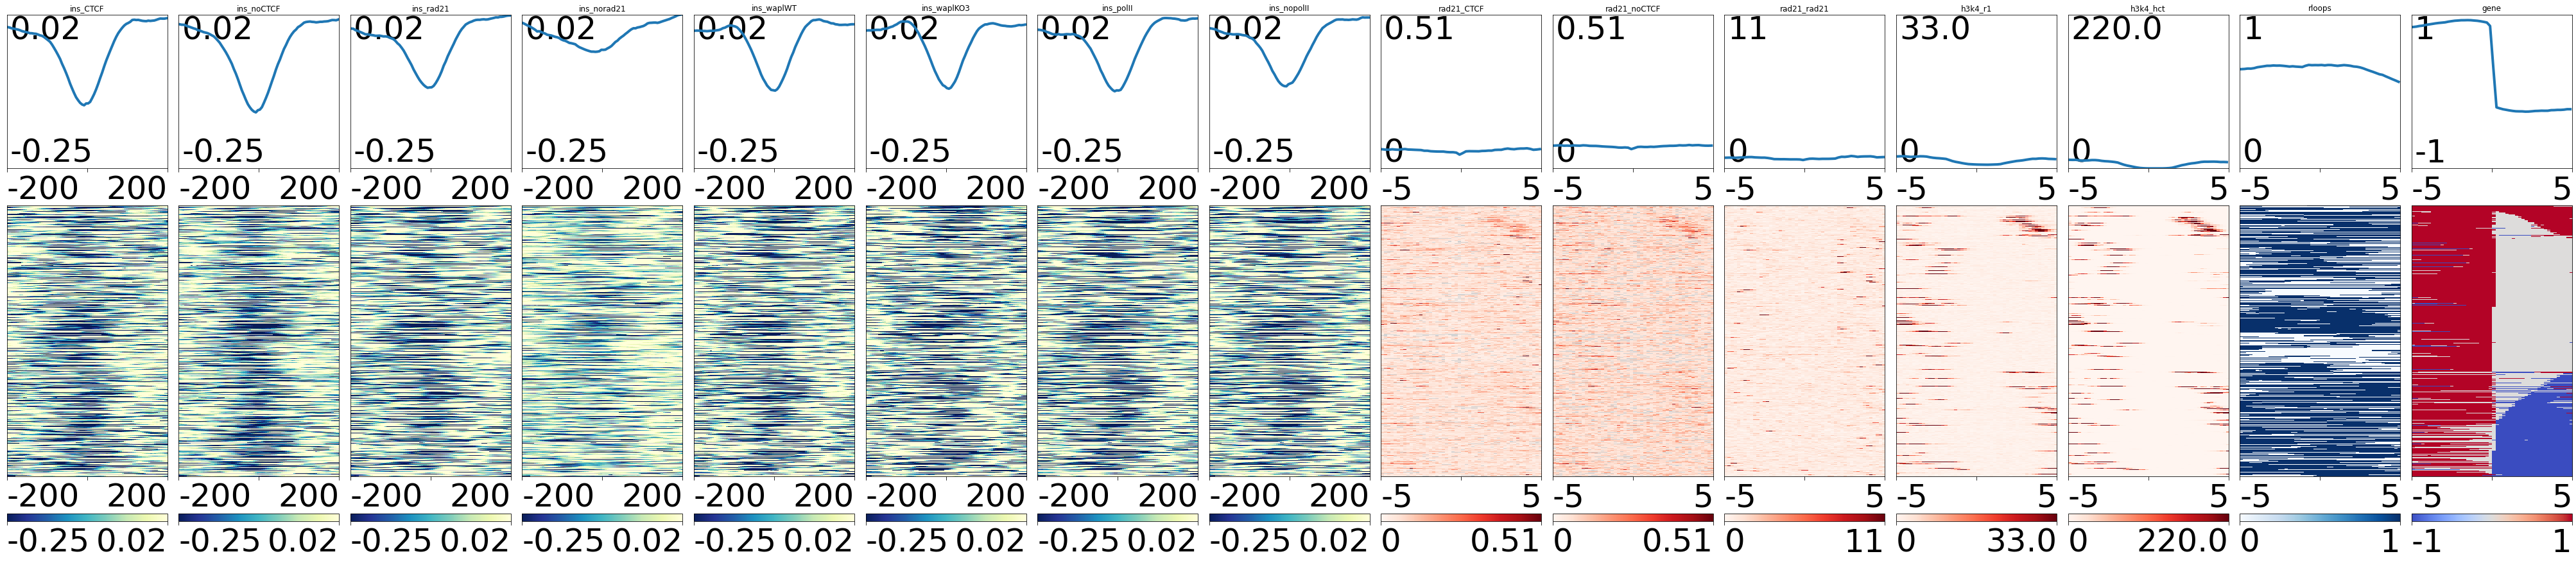

In [19]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    iii = reordered_jdxs[feature_key][:number_TTS_wrloop]
    # sub-sorting on the fly ...
    tmp_stackups = { k:flip_stackup_dict[feature_key][k][iii].copy() for k in bw_fnames }
    # for a given aset of stackups for a given list of features ...
    _,width = tmp_stackups['gene'].shape
    center_bin = int(width/2)
    tmp_stackups['gene_mean'] = np.nanmean(tmp_stackups['gene'][:,-center_bin:],axis=1)

    _sorting_key = 'gene_mean'
    _, _iii = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(tmp_stackups[_sorting_key]) ),
        data_dict = tmp_stackups,
        verbose=True
    )
    hmss[feature_key] = [ tmp_stackups[_k][_iii] for _k in fig2a_samples ]

_limss = [ limss[_k] for _k in fig2a_samples ]
_cmps = [ cmps[_k] for _k in fig2a_samples ]
_binsizes = [ binsizes[_k] for _k in fig2a_samples ]
_norms = [ norms[_k] for _k in fig2a_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
print("ready to plot ...")
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

In [20]:
# BELOW we generate some lists of TTS with and without R-loops but it does not seem to be used anywhere-
# likely - Anne-Laure have generated similar lists using bedtools ...

# save strong R-loop TSS and TTS to separate BED-files for future use ...
for feature_key in feat_names.keys():  # TTS only basically ...
    lll = reordered_jdxs[feature_key][:number_TTS_wrloop]
    # sub-sorting on the fly ...
    # display(dfs[feature_key].iloc[np.sort(lll)])
    dfs[feature_key].iloc[np.sort(lll)].to_csv(
        f"{feature_key}-rloops-strong-commonHAPHCT_Nov.bed",
        sep="\t",
        header=None,
        index=False
    )

    
# save strong R-loop TSS and TTS to separate BED-files for future use ...
for feature_key in feat_names.keys():
    lll = reordered_jdxs[feature_key][number_TTS_wrloop:]
    # sub-sorting on the fly ...
    # display(dfs[feature_key].iloc[np.sort(lll)])
    dfs[feature_key].iloc[np.sort(lll)].to_csv(
        f"{feature_key}-no-rloops-commonHAPHCT_Nov.bed",
        sep="\t",
        header=None,
        index=False
    )

    

In [ ]:
# !scp tts-*Nov.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/